## Fitting a function with *gradient descent*: The Remix!

In this notebook, I'll be *remixing* the original annotated journal I transcribed
using a new dataset applied to the same problem. With that out of the way, let's get started!

You might find it helpful to open the original journal alongside this one, as the order
in which we flesh out this notebook might be an exact match to the old one.

First, let's import our Jupyter notebook UI components and the fastai basic libraries.

In [308]:
from ipywidgets import interact
from fastai.basics import *

So, in the original notebook, we began by considering a **function**, specifically
a quadratic function. However, there are all kinds of functions out there! A function
is a mapping from a set of inputs to a set of outputs.

So, in this remixed notebook, let's consider a **function**, that maps **time** to 
some audio signal like an MP3!

In [309]:
from IPython.display import Audio

# Replace 'your_audio_file.mp3' with the path to your audio file
audio_path = 'assets/pronunciation_ja_冬.mp3'

# Display the audio player
Audio(audio_path)

With audio, there's two ways of looking at it: in the time domain and the 
frequency domain. Let's start with the time domain.

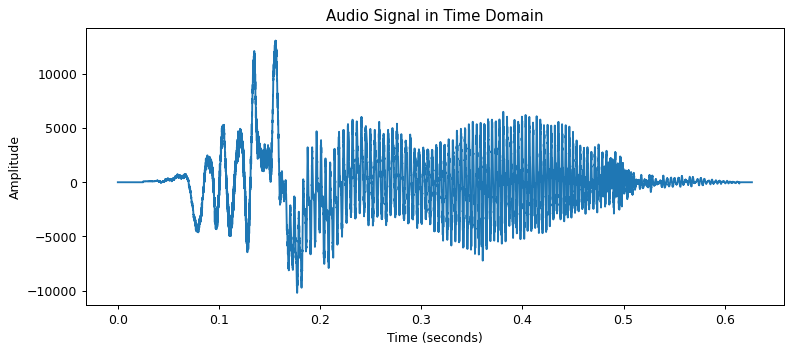

In [310]:
# Write a jupyter notebook code plots an mp3 file in the time domain
from pydub import AudioSegment

# Load the MP3 file
audio = AudioSegment.from_mp3(audio_path)

# Convert audio to NumPy array
samples = np.array(audio.get_array_of_samples())

# Get time values for the x-axis
time_values = np.arange(0, len(samples)) / audio.frame_rate

# Plot the audio in the time domain
plt.figure(figsize=(10, 4))
plt.title('Audio Signal in Time Domain')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.plot(time_values, samples)

Simple enough, you're probably most familiar with seeing audio in the 
time domain. But there's also the frequency domain, where we consider all the 
frequencies present in the audio signal.

(0.0, 22050.0)

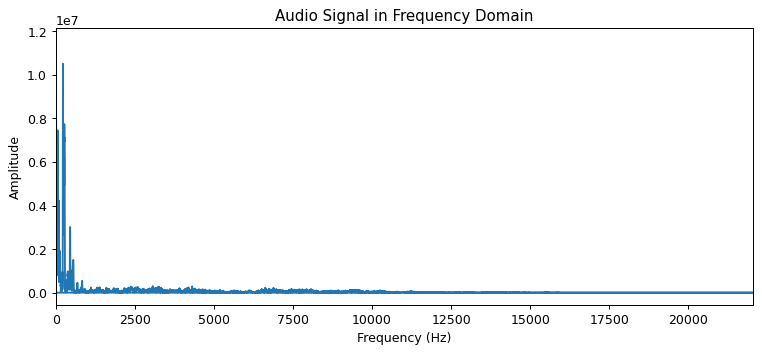

In [311]:
# Write a jupyter notebook script that plots an mp3 file in the frequency domain

# Load the MP3 file
audio = AudioSegment.from_mp3(audio_path)

# Apply Fast Fourier Transform (FFT)
fft_result = np.fft.fft(samples)

# Get frequency values for the x-axis
freq_values = np.fft.fftfreq(len(samples), 1.0 / audio.frame_rate)

# Plot the audio in the frequency domain
plt.figure(figsize=(10, 4))
plt.plot(freq_values, np.abs(fft_result))
plt.title('Audio Signal in Frequency Domain')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, audio.frame_rate / 2)  # Display only positive frequencies

You might notice that the frequency signal is right tailed, this is because it
is a single sound, imagine is a band were playing music, with each instrument having 
different frequencies, we'd see various peaks here!

Okay now that we've introduced our function, let's get back to the original notebook.

Next, let's define a function, called `plot_function` that plots a function `f`.

In `pytorch` and similar libraries like `numpy`, you need to define your inputs `x`
as a list of values, the `linspace` function does this for you, the example below
creates a list of values from our `min` parameter to the `max` parameter with 100
discrete values between them.

Now, let's create a function `audio_function_t`, that returns a function of our
audio signal in the time domain.

In [312]:
def audio_function_t(file_path) -> (time_values,samples): 
  '''
  Returns a tuple with x, and y, corresponding to the time domain signal of an
  mp3 file
  '''
  # Load the MP3 file
  audio = AudioSegment.from_mp3(file_path)

  # Convert audio to NumPy array
  samples = np.array(audio.get_array_of_samples())

  # Get time values for x-axis
  time_values = np.arange(0, len(samples)) / audio.frame_rate

  # Return the tuple (x, y)
  return torch.tensor(time_values), torch.tensor(samples)

/var/folders/_w/bh_j30t942qdttqw2d3mpzqw0000gn/T/ipykernel_26909/2799920921.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)
/var/folders/_w/bh_j30t942qdttqw2d3mpzqw0000gn/T/ipykernel_26909/2799920921.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)


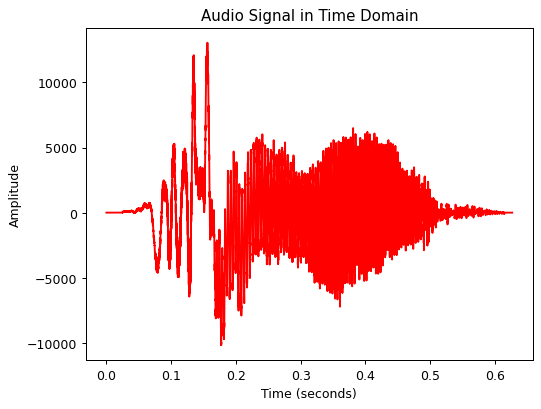

In [313]:
plt.rc('figure', dpi=90)

def plot_audio_function(f, file_path, title=None, xlabel=None, ylabel=None, min=-2.1, max=2.1, 
                        sample_count=100, color='r', ylim=None):
    x, y = f(file_path)
    x = torch.tensor(x)
    y = torch.tensor(y)
    if ylim: plt.ylim(ylim)
    plt.plot(x, y, color)
    if title is not None: plt.title(title)
    if xlabel is not None: plt.xlabel(xlabel)
    if ylabel is not None: plt.ylabel(ylabel)

plot_audio_function(audio_function_t, audio_path, "Audio Signal in Time Domain", 'Time (seconds)', 'Amplitude')

Now, to start approximating this function using machine learning. Let's create
some "test" data by using two functions, `noise` and `add_noise`. `noise` draws 
random values from a normal distribution, using `scale` as the standard deviation.

`add_noise` takes some domain `x`, and then scales and translates the points in `x` randomly.

In [314]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

In [315]:
np.random.seed(42)

x, y = audio_function_t(audio_path)

y = add_noise(y, 0.5, 2.0)

In [316]:
x[:5],y[:5]

(tensor([0.0000e+00, 2.2676e-05, 4.5351e-05, 6.8027e-05, 9.0703e-05],
        dtype=torch.float64),
 tensor([ 0.5794, -2.4083, -1.3206, -4.4231,  1.2116], dtype=torch.float64))

If we plot `x` and `y` this will make more sense but it is good to understand the
code as well.

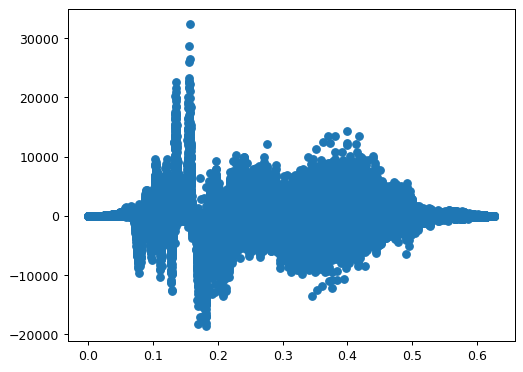

In [317]:
plt.scatter(x,y);

# Creating a model function

In order to approximate the function, we to create some model for how it should look.

In the original notebook, we learned about RelU functions, and how if you add them together
and strategically play with their parameters , you can approximate any function.

In this notebook, we will use multiple (possibly hundreds) of RelU functions to 
approximate the function of our audio.

To help gain an understanding of what we mean here, let's revisit the RelU function.

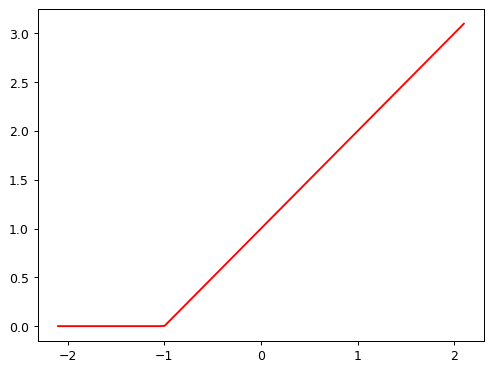

In [318]:
import torch.nn.functional as F

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)
    
def rectified_linear2(m,b,x): return F.relu(m*x+b)
plot_function(partial(rectified_linear2, 1,1))

Also recall what a double relu function looks like.

In [319]:
def double_relu(m1,b1,m2,b2,x):
    return F.relu(m1*x+b1) + F.relu(m2*x+b2)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

... and a triple relu...see where we're going with this?

In [320]:
def triple_relu(m1, b1, m2, b2, m3, b3, x):
    return F.relu(m1*x + b1) + F.relu(m2*x + b2) + F.relu(m3*x + b3)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5, m3=-1.0, b3=0.5)
def plot_triple_relu(m1, b1, m2, b2, m3, b3):
    plot_function(partial(triple_relu, m1, b1, m2, b2, m3, b3), ylim=(-1, 9)
                  ,max=10.0)

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

Let's create a model that uses multiple RelU's to fit some data.

In [321]:
# Write a function that returns N-Many RelUs
def n_relu(*args, x):
    return sum(F.relu((a*(x+b)) + c) for a, b, c in args)

# Example usage:
# Specify N sets of parameters (slope, bias)
# relu_parameters = [(1.0, 0.0), (0.5, -1.0), (2.0, 1.5)]

Let's start by generating a random N-Many RelU function, with random parameters.

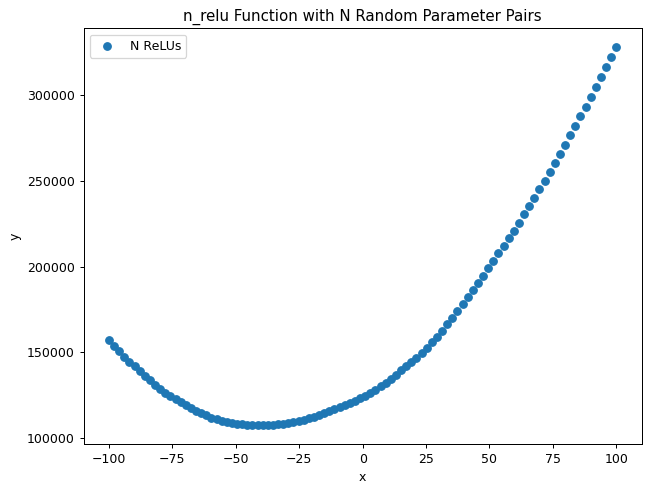

In [322]:
# Intantiate a n_relu function with N random parameter pairs

def instantiate_n_relu(N, random_parameters=None):
    # Generate N random parameter pairs
    if random_parameters == None: 
        random_parameters = torch.tensor([(random.uniform(-100, 100), random.uniform(-100, 100), random.uniform(-100, 100)) for _ in range(N)])
    
    # Create and return the n_relu function with the random parameters
    return lambda x: n_relu(*random_parameters, x=x)

# Example usage:
N = 100  # Set the desired number of ReLUs

# Instantiate n_relu function with N random parameter pairs
random_n_relu = instantiate_n_relu(N)

def plot_n_relu(f):
    x_values = torch.linspace(-100, 100, 100)
    y_values = f(x_values)

    plt.figure(figsize=(8, 6))
    plt.scatter(x_values, y_values, label='N ReLUs')
    plt.title('n_relu Function with N Random Parameter Pairs')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

plot_n_relu(random_n_relu)

How can we gain insight into how "correct" our guess was? Well we can calculate the average
error between the predicted values in our "red" line, and the corresponding "blue" points.
The `mae` function does just that.

In [323]:
def mae(preds, acts): return (torch.abs(preds-acts)).mean()

## Automating gradient descent

That manual process you just played with is how computers can solve problems like
this one automatically, by trying to minimize our **loss function**
(the average error between the predicted values and the actual values).

In [324]:
def quad_mae(params):
    f = mk_quad(*params)
    return mae(f(x), y)

In [325]:
def audio_mae(params):
    f = instantiate_n_relu(N, params)
    return mae(f(x), y)

def make_random_params(min_x=-100, max_x=100,min_y=-100, max_y=100): return torch.tensor([(random.uniform(min_x, max_x), random.uniform(min_x, max_x), random.uniform(min_y, max_y)) for _ in range(N)])

In [326]:
audio_mae(make_random_params())

tensor(118612.2904, dtype=torch.float64)

Now instead of using a python list for our function coefficients, let's use a tensor.

In [327]:
params = make_random_params(min_x=min(x), max_x=max(x),min_y=min(y), max_y=max(y))

The gradient of a function defines the rate at which it's
value changes as we change the values of the input variables. `requires_grad` is
a function that calculates the gradient of every value in our tensor `abc` for us
as computations are made using the tensor.

In [328]:
params.requires_grad_()

tensor([[ 9.2039e-02,  5.8460e-01,  4.7440e+03],
        [ 5.7431e-01,  5.3855e-01, -1.4120e+04],
        [ 3.3731e-02,  1.2075e-01,  1.2614e+04],
        [ 3.7270e-01,  3.9821e-01, -1.1045e+04],
        [ 4.7853e-01,  2.5739e-01,  1.9184e+04],
        [ 4.4429e-01,  3.3785e-01,  2.9974e+04],
        [ 4.0033e-01,  5.2242e-01,  1.4748e+04],
        [ 8.5086e-03,  4.7169e-01,  5.3497e+03],
        [ 1.2374e-01,  1.8355e-01, -1.7104e+04],
        [ 3.9398e-01,  3.3126e-01,  9.1284e+02],
        [ 6.0973e-01,  1.9315e-01,  1.0225e+04],
        [ 9.3402e-02,  1.3366e-01,  2.9425e+03],
        [ 1.6785e-01,  1.7910e-01, -3.6556e+02],
        [ 2.3157e-01,  1.5173e-01, -2.4955e+03],
        [ 4.5719e-01,  2.8357e-02,  2.6374e+04],
        [ 1.1362e-02,  9.9134e-03,  2.0731e+04],
        [ 1.3198e-01,  2.2150e-01, -1.6945e+03],
        [ 3.4310e-01,  8.9863e-03,  3.1494e+04],
        [ 3.5935e-01,  2.2910e-01, -3.2656e+03],
        [ 2.8543e-01,  6.8158e-02,  2.4559e+04],
        [ 3.5974e-01

So now, if we calculate the loss of our function, we'll get the gradient of the 
loss for each coefficient!

In [329]:
loss = audio_mae(params)
loss

tensor(1264070.8173, dtype=torch.float64, grad_fn=<MeanBackward0>)

Now let's compute the gradient on this tensor and all of the tensors involved in calulating
it, *ahem* like the `abc` tensor!

In [330]:
loss.backward()

Now if we call `.grad` on `abc`, we'll get the gradient of each parameter!

In [331]:
params.grad

tensor([[0.8981, 0.0920, 1.0000],
        [0.0000, 0.0000, 0.0000],
        [0.4342, 0.0337, 1.0000],
        [0.0000, 0.0000, 0.0000],
        [0.5709, 0.4785, 1.0000],
        [0.6513, 0.4443, 1.0000],
        [0.8359, 0.4003, 1.0000],
        [0.7852, 0.0085, 1.0000],
        [0.0000, 0.0000, 0.0000],
        [0.6447, 0.3940, 1.0000],
        [0.5066, 0.6097, 1.0000],
        [0.4471, 0.0934, 1.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.3418, 0.4572, 1.0000],
        [0.3234, 0.0114, 1.0000],
        [0.0000, 0.0000, 0.0000],
        [0.3224, 0.3431, 1.0000],
        [0.0000, 0.0000, 0.0000],
        [0.3816, 0.2854, 1.0000],
        [0.4109, 0.3597, 1.0000],
        [0.7459, 0.1035, 1.0000],
        [0.8648, 0.2782, 1.0000],
        [0.8730, 0.4477, 1.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.4113, 0.5616, 1.0000],
        [0.5177, 0.0720, 1.0000],
        [0.738

Now what if we updated our parameters by subtracting the gradient from them? Would our loss go down?

In [332]:
with torch.no_grad():
    params -= params.grad*0.01
    loss = audio_mae(params)
    
print(f'loss={loss:.2f}')

loss=1264069.69


It did! Only by a little bit though, what if we iterated on that, I don't know... say 10 times?

In [333]:
for i in range(25):
    loss = audio_mae(params)
    loss.backward()
    with torch.no_grad(): params -= params.grad*0.5
    print(f'step={i}; loss={loss:.2f}')

step=0; loss=1264069.69
step=1; loss=1263970.92
step=2; loss=1263840.14
step=3; loss=1263563.21
step=4; loss=1262763.78
step=5; loss=1260099.50
step=6; loss=1250161.77
step=7; loss=1211143.08
step=8; loss=1070306.00
step=9; loss=668192.37
step=10; loss=343790.43
step=11; loss=180391.78
step=12; loss=111392.90
step=13; loss=79591.54
step=14; loss=26545.79
step=15; loss=16919.53
step=16; loss=2479.75
step=17; loss=1890.43
step=18; loss=1890.43
step=19; loss=1890.43
step=20; loss=1890.43
step=21; loss=1890.43
step=22; loss=1890.43
step=23; loss=1890.43
step=24; loss=1890.43


Now that we've updated our loss a ton, let's plot the final function

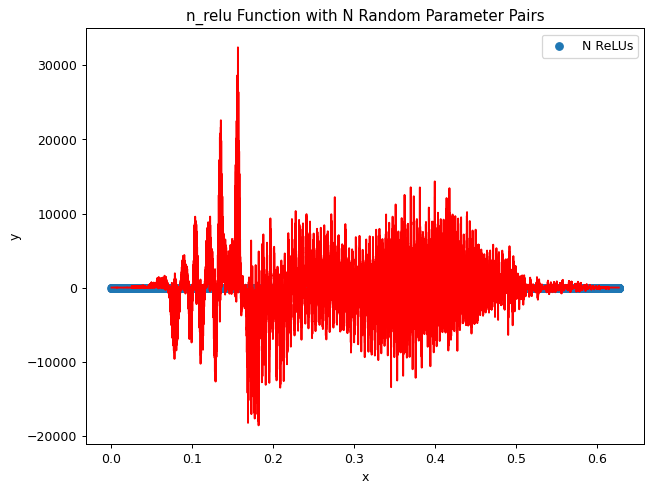

In [334]:
def plot_n_relu(f):
    y_values = f(x).detach().numpy()

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y_values, label='N ReLUs')
    plt.plot(x, y, color='red')
    plt.title('n_relu Function with N Random Parameter Pairs')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

plot_n_relu(lambda x: n_relu(*params, x=x))

Notice how with every "step" our loss value shrinks! Isn't that cool?